In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import linkage

## Reading and Cleaning Data

In [2]:
df=pd.read_csv("Country-data.csv")

In [3]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
df.shape

(167, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
#Checking for null values
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [7]:
#Therefore no Null values and columns are also in correct data format

## Cleaniing Data 

#### There are some columns which are in percentage form, we will convert them into normal values.

In [8]:
df["exports"]=(df["exports"]*df["gdpp"])/100

df["health"]=(df["health"]*df["gdpp"])/100

df["imports"]=(df["imports"]*df["gdpp"])/100

In [9]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## EDA

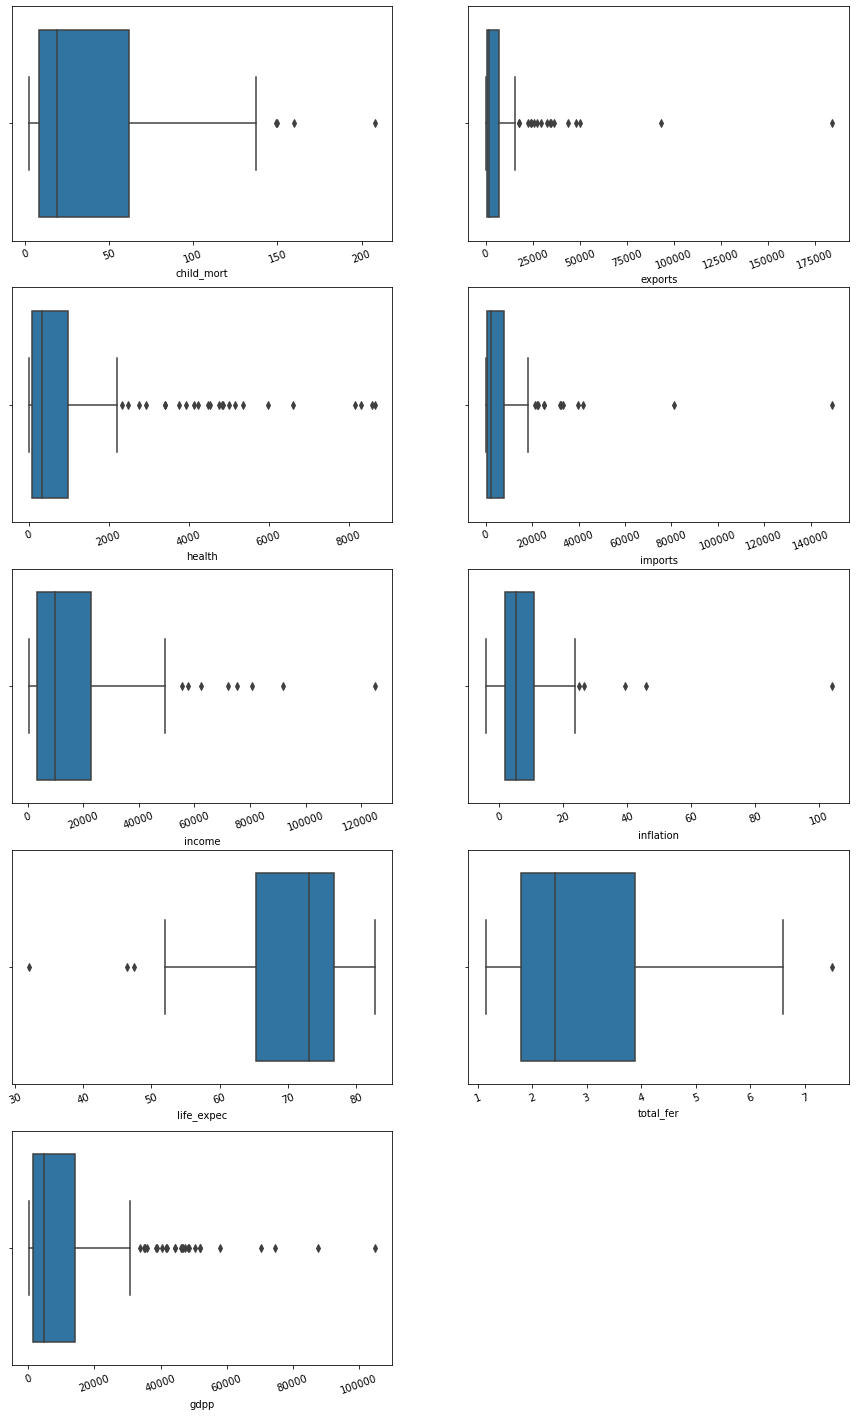

In [11]:
plt.figure(figsize=(15,25))
features=["child_mort","exports","health","imports","income","inflation","life_expec","total_fer","gdpp"]
for i in enumerate(features):
    ax=plt.subplot(5,2,i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation=20)
    

### There are outliers in every column

## Outliers treatment

In [12]:
def outlier_treatment(df,col):
    Q1= df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    
    IQR=Q3-Q1
    
    lower_cap=Q1-1.5*IQR
    
    higher_cap=Q3+1.5*IQR
    
    df.loc[(df[col]>higher_cap),col]=higher_cap
    df.loc[(df[col]<lower_cap),col]=lower_cap
    
    return df

In [13]:
df=outlier_treatment(df,"child_mort")
df=outlier_treatment(df,"exports")
df=outlier_treatment(df,"health")
df=outlier_treatment(df,"imports")
df=outlier_treatment(df,"income")
df=outlier_treatment(df,"inflation")
df=outlier_treatment(df,"life_expec")
df=outlier_treatment(df,"total_fer")
df=outlier_treatment(df,"gdpp")

In [14]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,37.698204,4710.954895,680.241240,4756.898995,15921.574850,7.065066,70.663772,2.945075,10351.281437
std,38.443293,5832.960967,804.768458,5690.687520,15207.197459,6.704968,8.522535,1.505564,11612.044330
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,48.050000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,142.875000,17524.290000,2324.546750,18338.677500,51967.500000,24.160000,82.800000,7.007500,33130.000000


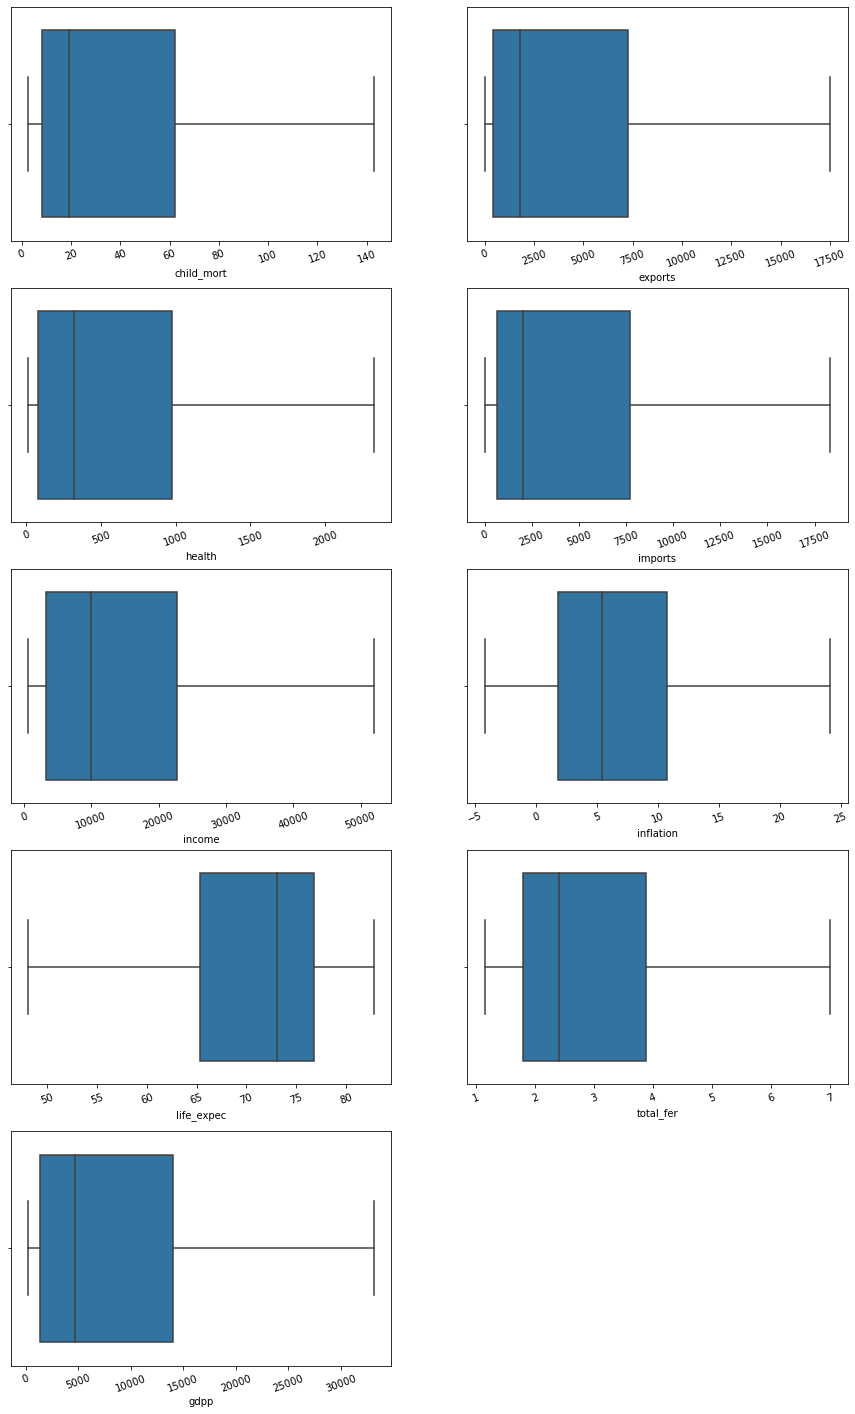

In [18]:
#Lets check for the outliers again
plt.figure(figsize=(15,25))
features=["child_mort","exports","health","imports","income","inflation","life_expec","total_fer","gdpp"]
for i in enumerate(features):
    ax=plt.subplot(5,2,i[0]+1)
    sns.boxplot(df[i[1]])
    plt.xticks(rotation=20)

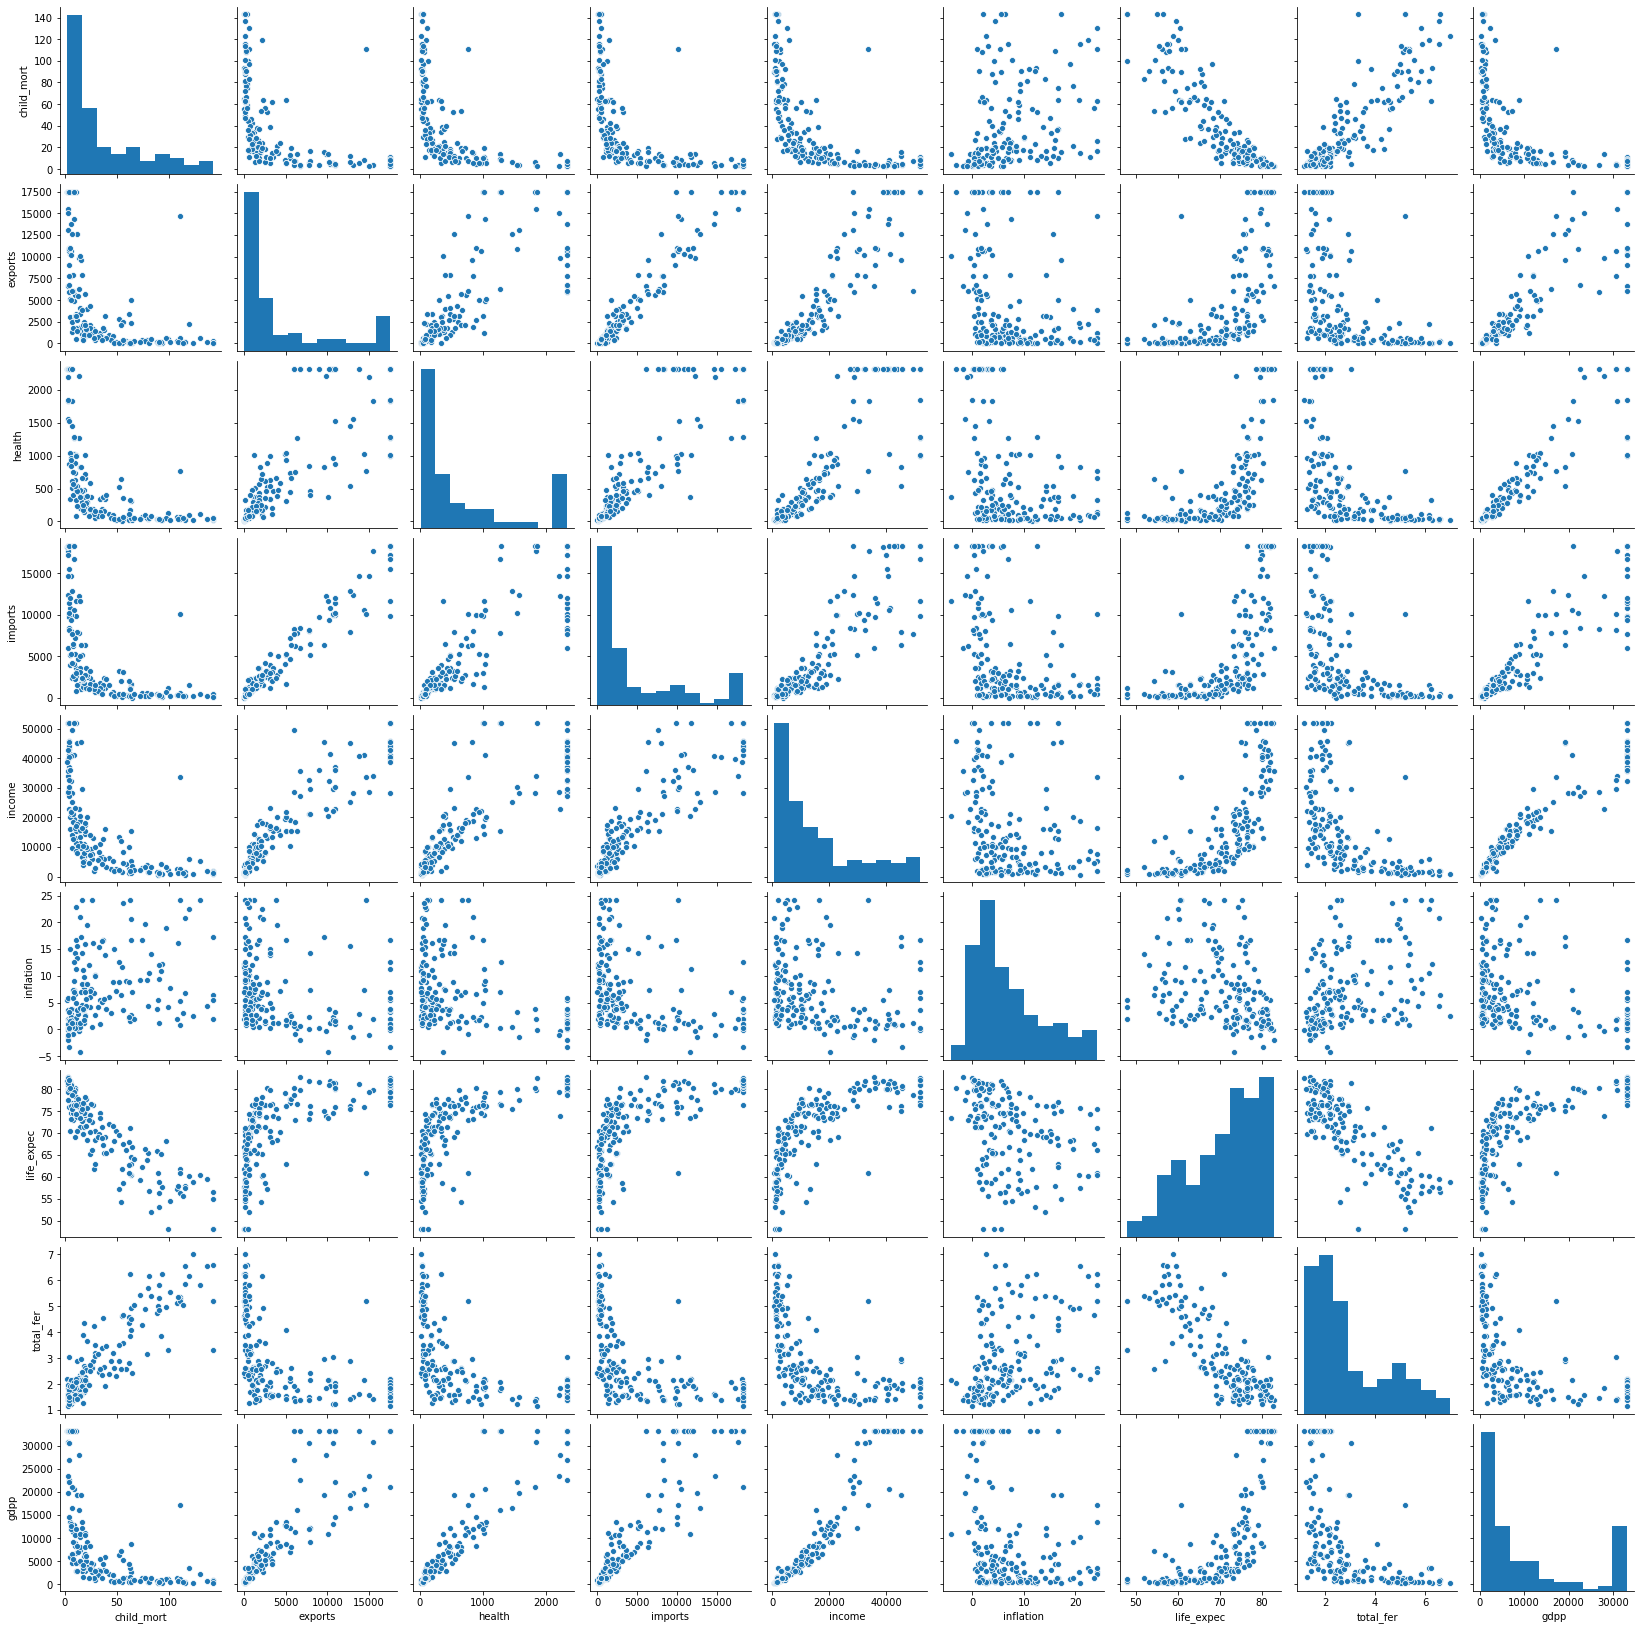

In [19]:
sns.pairplot(df)
plt.show()

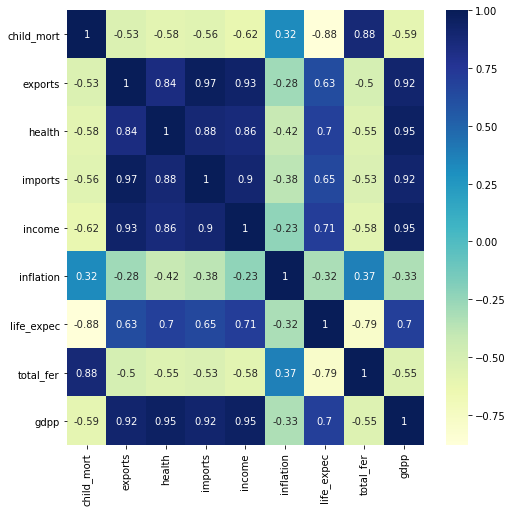

In [20]:
#Lets look at the corelation matrix as well
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")
plt.show()

## Clustering

### Hopkin's Test

In [27]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [28]:
hopkins(df.drop("country",axis=1))

0.9301916857579408

### Hopkin's test shows that the data is goof for performing clustering

## Scaling Data

In [29]:
df1=df.drop("country",axis=1)

In [30]:
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0


In [31]:
standard_scaler=StandardScaler()
df1=standard_scaler.fit_transform(df1)

In [33]:
df1

array([[ 1.36980194, -0.80056371, -0.79556251, ..., -1.70222504,
         1.91527602, -0.84634107],
       [-0.55046422, -0.61314982, -0.51391972, ...,  0.66332125,
        -0.86277926, -0.54082746],
       [-0.27129509, -0.51557561, -0.6160104 , ...,  0.68685903,
        -0.03669088, -0.50886816],
       ...,
       [-0.37565738, -0.64788476, -0.73612924, ...,  0.28671687,
        -0.66291917, -0.78095407],
       [ 0.48533152, -0.74249447, -0.76323195, ..., -0.37234081,
         1.14914567, -0.78095407],
       [ 1.18455887, -0.71718267, -0.7406285 , ..., -2.19651829,
         1.63547189, -0.7679976 ]])

In [34]:
#Converting it back to Dataframe, standardscaler() returns a numpy array
df1=pd.DataFrame(df1,columns=["child_mort","exports","health","imports","income","inflation","life_expec","total_fer","gdpp"])

In [35]:
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.369802,-0.800564,-0.795563,-0.794660,-0.943936,0.355270,-1.702225,1.915276,-0.846341
1,-0.550464,-0.613150,-0.513920,-0.488076,-0.395181,-0.385208,0.663321,-0.862779,-0.540827
2,-0.271295,-0.515576,-0.616010,-0.591590,-0.199291,1.351551,0.686859,-0.036691,-0.508868
3,2.121210,-0.431911,-0.722418,-0.571509,-0.660984,2.293979,-1.243238,2.141784,-0.589198
4,-0.714835,0.144450,0.069070,0.428104,0.209637,-0.841463,0.722166,-0.543003,0.159686


## KMeans Clustering

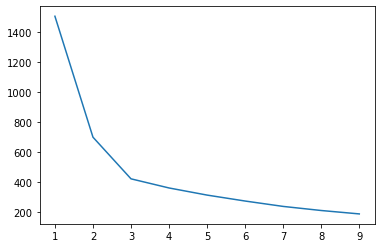

In [37]:
#Finding Optimal Number of cluster
# Elbow Curves
ssd=[]
for k in list(range(1,10)):
    model=KMeans(n_clusters=k,max_iter=50).fit(df1)
    ssd.append([k,model.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0],pd.DataFrame(ssd)[1]);

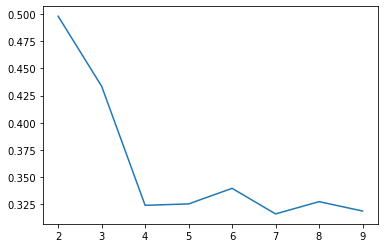

In [41]:
ss=[]
for k in range(2,10):
    kmeans=KMeans(n_clusters=k).fit(df1)
    ss.append([k,silhouette_score(df1,kmeans.labels_)])
    
plt.plot(pd.DataFrame(ss)[0],pd.DataFrame(ss)[1])

In [42]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df1)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df1, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.49089694803242895
For n_clusters=3, the silhouette score is 0.43360177139259876
For n_clusters=4, the silhouette score is 0.32436810285701795
For n_clusters=5, the silhouette score is 0.3281197983100398
For n_clusters=6, the silhouette score is 0.2903375507650858
For n_clusters=7, the silhouette score is 0.31610359321224474
For n_clusters=8, the silhouette score is 0.32676904913861315


## Optimal Number of Clusters is equal to 3

### Initialising kmeans

In [43]:
kmeans=KMeans(n_clusters=3,max_iter=100,random_state=100)
kmeans.fit(df1)

KMeans(max_iter=100, n_clusters=3, random_state=100)

In [47]:
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2,
       1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [49]:
#Keeping our original data safe
df_org=df.copy()

In [51]:
df_km=pd.concat([df,pd.Series(kmeans.labels_)],axis=1)
df_km.columns=["country","child_mort","exports","health","imports","income","inflation","life_expec","total_fer","gdpp","cluster_id"]
df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


In [52]:
df_km["cluster_id"].value_counts()

2    78
1    48
0    41
Name: cluster_id, dtype: int64

## KMeans Cluster Visualisation

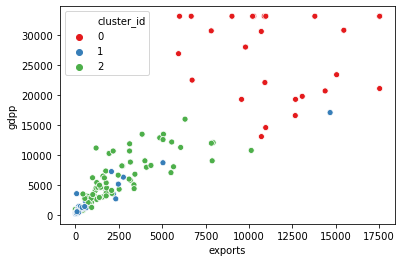

In [53]:
sns.scatterplot(x="exports",y="gdpp",hue="cluster_id",legend="full",data=df_km,palette="Set1")
plt.show()

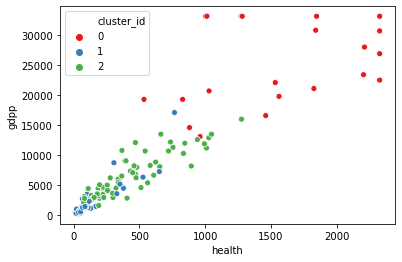

In [54]:
sns.scatterplot(x="health",y="gdpp",hue="cluster_id",legend="full",data=df_km,palette="Set1")
plt.show()

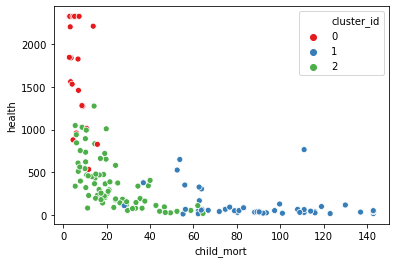

In [55]:
sns.scatterplot(x="child_mort",y="health",hue="cluster_id",legend="full",data=df_km,palette="Set1")
plt.show()

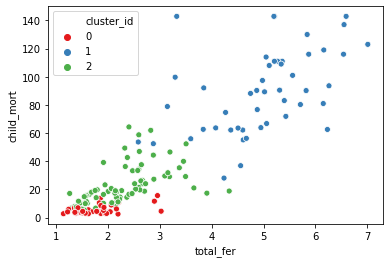

In [56]:
sns.scatterplot(x="total_fer",y="child_mort",hue="cluster_id",legend="full",data=df_km,palette="Set1")
plt.show()

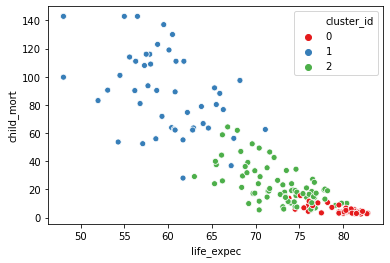

In [57]:
sns.scatterplot(x="life_expec",y="child_mort",hue="cluster_id",legend="full",data=df_km,palette="Set1")
plt.show()

## KMeans Clustering Profiling

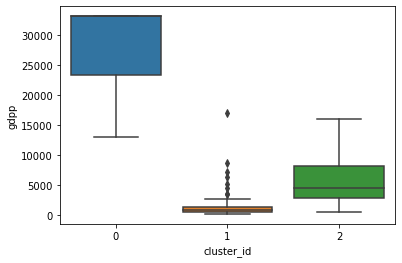

In [58]:
sns.boxplot(data=df_km,x="cluster_id",y="gdpp")
plt.show()

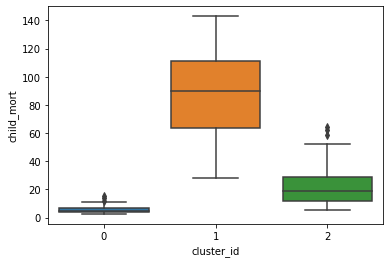

In [59]:
sns.boxplot(data=df_km,x="cluster_id",y="child_mort")
plt.show()

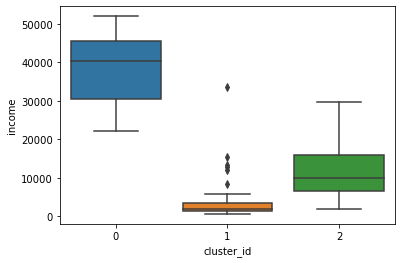

In [60]:
sns.boxplot(data=df_km,x="cluster_id",y="income")
plt.show()

### Cluster_id 1  has very low income and gdpp and very high child mortality rate therefore this cluster will be our prime focus.

In [61]:
#Finding the observations that belong to cluster id 1
df_km[df_km["cluster_id"]==1]["country"]

0                   Afghanistan
3                        Angola
17                        Benin
21                     Botswana
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106     

In [62]:
top_kmeans=df_km[df_km["cluster_id"]==1].sort_values(by=["child_mort","gdpp","income"],ascending=[False,True,True])
top_kmeans=top_kmeans.reset_index().drop("index",axis=1)
top_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Sierra Leone,142.875,67.032,52.2690,137.655,1220.0,17.20,55.00,5.20,399.0,1
1,Central African Republic,142.875,52.628,17.7508,118.190,888.0,2.01,48.05,5.21,446.0,1
2,Haiti,142.875,101.286,45.7442,428.314,1500.0,5.45,48.05,3.33,662.0,1
3,Chad,142.875,330.096,40.6341,390.195,1930.0,6.39,56.50,6.59,897.0,1
4,Mali,137.000,161.424,35.2584,248.508,1870.0,4.37,59.50,6.55,708.0,1


In [63]:
top_10=top_kmeans.iloc[:10]
top_10["country"].reset_index().drop("index",axis=1)

,country
0,Sierra Leone
1,Central African Republic
2,Haiti
3,Chad
4,Mali
5,Nigeria
6,Niger
7,Angola
8,"Congo, Dem. Rep."
9,Burkina Faso


## Top 10 countries obtained from K-Means Models are:
-	Sierra Leone
-   Central African Republic
-	Haiti
-	Chad
-	Mali
-	Nigeria
-	Niger
-	Angola
-	Congo, Dem. Rep.
-	Burkina Faso

## Heirarichal Clustering

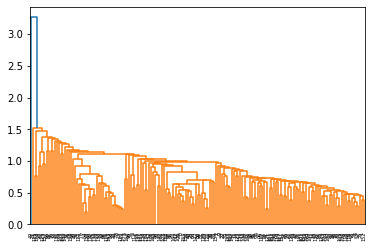

In [64]:
mergings_single=linkage(df1,method="single",metric="euclidean")
dendrogram(mergings_single)
plt.show()

### Clusters are not forming correctly in single linkage so we will not use single linkage and proceed with complete linkage

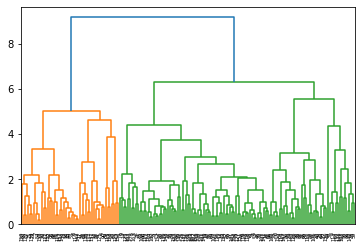

In [65]:
mergings_complete=linkage(df1,method="complete",metric="euclidean")
dendrogram(mergings_complete)
plt.show()

### Looking at dendrogram of hierarchical clustering there seems to be 3 clusters.

In [67]:
cluster_labels=cut_tree(mergings_complete,n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0,
       0, 2, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [70]:
df_hm=pd.concat([df,pd.Series(cluster_labels)],axis=1)
df_hm.columns=["country","child_mort","exports","health","imports","income","inflation","life_expec","total_fer","gdpp","cluster_labels"]
df_hm.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


In [71]:
df_hm["cluster_labels"].value_counts()

1    75
2    49
0    43
Name: cluster_labels, dtype: int64

## Heirarchical Clusters Visualisation

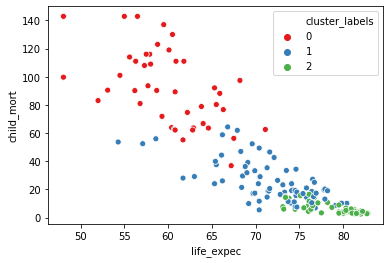

In [72]:
sns.scatterplot(x = 'life_expec', y = 'child_mort', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

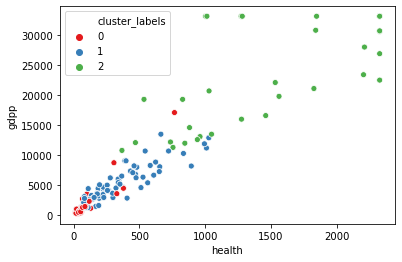

In [73]:
sns.scatterplot(x = 'health', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

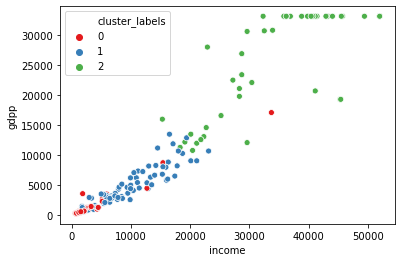

In [74]:
sns.scatterplot(x = 'income', y = 'gdpp', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

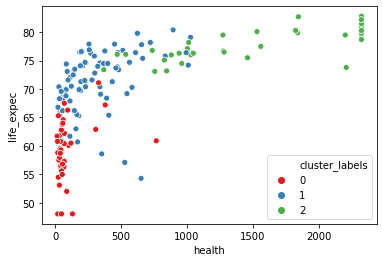

In [75]:
sns.scatterplot(x = 'health', y = 'life_expec', hue ='cluster_labels', legend = 'full', data = df_hm, palette='Set1')
plt.show()

## Cluster Profiling

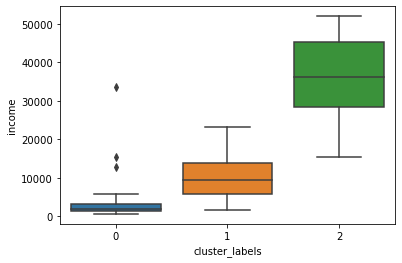

In [76]:
sns.boxplot(data=df_hm,x = 'cluster_labels',y='income')
plt.show()

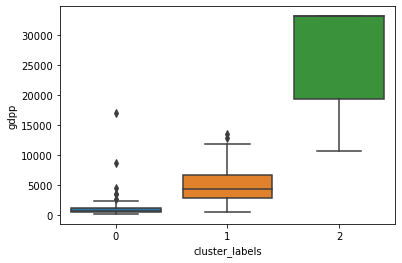

In [77]:
sns.boxplot(data=df_hm,x = 'cluster_labels',y='gdpp')
plt.show()

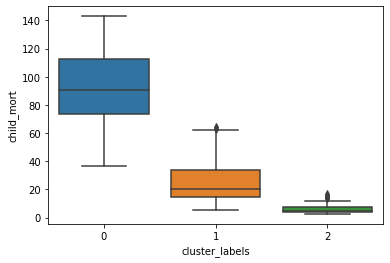

In [78]:
sns.boxplot(data=df_hm,x = 'cluster_labels',y='child_mort')
plt.show()

### Cluster 0 have low income , low gdpp and high child_mort rate.

## Finding the observations that belong to cluster 0

In [79]:
df_hm[df_hm['cluster_labels']==0]['country']

0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106                  Mozambique
112                       Niger
113     

In [80]:
top_h = df_hm[df_hm['cluster_labels']==0].sort_values(by=["child_mort","gdpp","income"], ascending=[False, True,True]) 
top_h = top_h.reset_index().drop('index',1)
top_h.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Sierra Leone,142.875,67.032,52.2690,137.655,1220.0,17.20,55.00,5.2000,399.0,0
1,Central African Republic,142.875,52.628,17.7508,118.190,888.0,2.01,48.05,5.2100,446.0,0
2,Haiti,142.875,101.286,45.7442,428.314,1500.0,5.45,48.05,3.3300,662.0,0
3,Chad,142.875,330.096,40.6341,390.195,1930.0,6.39,56.50,6.5900,897.0,0
4,Mali,137.000,161.424,35.2584,248.508,1870.0,4.37,59.50,6.5500,708.0,0
5,Nigeria,130.000,589.490,118.1310,405.420,5150.0,24.16,60.50,5.8400,2330.0,0
6,Niger,123.000,77.256,17.9568,170.868,814.0,2.55,58.80,7.0075,348.0,0
7,Angola,119.000,2199.190,100.6050,1514.370,5900.0,22.40,60.10,6.1600,3530.0,0
8,"Congo, Dem. Rep.",116.000,137.274,26.4194,165.664,609.0,20.80,57.50,6.5400,334.0,0
9,Burkina Faso,116.000,110.400,38.7550,170.200,1430.0,6.81,57.90,5.8700,575.0,0


In [81]:
top_10 = top_h.iloc[:10]
top_10['country'].reset_index().drop('index',axis=1)

,country
0,Sierra Leone
1,Central African Republic
2,Haiti
3,Chad
4,Mali
5,Nigeria
6,Niger
7,Angola
8,"Congo, Dem. Rep."
9,Burkina Faso


### Top 10 Countries obtained from Hierarchical Models are.
-	Sierra Leone
-	Central African Republic
-	Haiti
-	Chad
-	Mali
-	Nigeria
-	Niger
-	Angola
-	Congo, Dem. Rep.
-	Burkina Faso